In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report
import time

teams = pd.read_csv("data_prepared/teams.csv")
teams = teams.drop(columns=['teams_firstRound', 'teams_semis', 'teams_finals', 'teams_rank', 'teams_post_W', 'teams_post_L'])
teams['teams_playoff'] = teams['teams_playoff'].map({'Y': 1, 'N': 0})
teams['teams_confID'] = teams['teams_confID'].map({'EA': 0, 'WE': 1})


players = pd.read_csv("data_prepared/players_teams.csv")
players = players.drop(columns=['teams_firstRound', 'teams_semis', 'teams_finals', 'teams_rank', 'teams_post_W', 'teams_post_L'])
players['teams_playoff'] = players['teams_playoff'].map({'Y': 1, 'N': 0})
players['teams_confID'] = players['teams_confID'].map({'EA': 0, 'WE': 1})

def encode_categorical_columns(df):
    label_encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if col == 'teams_playoff' or col == 'teams_confID':
            continue
        else:
            df[col] = label_encoder.fit_transform(df[col])
    return df

encode_categorical_columns(teams)
encode_categorical_columns(players)

,players_teams_playerID,players_teams_year,players_teams_stint,players_teams_tmID,players_teams_GP,players_teams_GS,players_teams_minutes,players_teams_points,players_teams_oRebounds,players_teams_dRebounds,...,teams_d_blk,teams_won,teams_lost,teams_homeW,teams_confW,teams_confL,teams_min,teams_attend,teams_awards_players,teams_awards_coaches
0,0,2,0,10,26,23,846,343,43,131,...,126,12,20,6,9,12,6475,120607,0,0
1,0,3,0,10,27,27,805,314,45,101,...,117,10,22,7,6,15,6475,139874,0,0
2,0,4,0,10,30,25,792,318,44,97,...,126,18,16,11,14,10,6850,120253,0,0
3,0,5,0,10,22,11,462,146,17,57,...,133,18,16,11,12,10,6850,125097,1,1
4,0,6,0,10,31,31,777,304,29,78,...,144,14,20,11,9,13,6850,113447,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,550,3,2,12,5,0,37,6,0,3,...,127,11,21,10,7,14,6400,139798,1,0
1872,551,6,0,16,34,4,413,90,11,28,...,154,20,14,14,13,9,6825,151150,0,0
1873,552,10,0,5,34,4,802,406,25,81,...,110,18,16,11,11,11,6975,136069,0,0
1874,553,4,0,17,6,0,30,11,0,2,...,119,9,25,3,7,17,6875,238710,0,0


--- First Conference ---

Time: 0.03 segundos
Precision: 0.76
Recall: 0.79
F1: 0.78
Accuracy: 0.72
AUC: 0.71


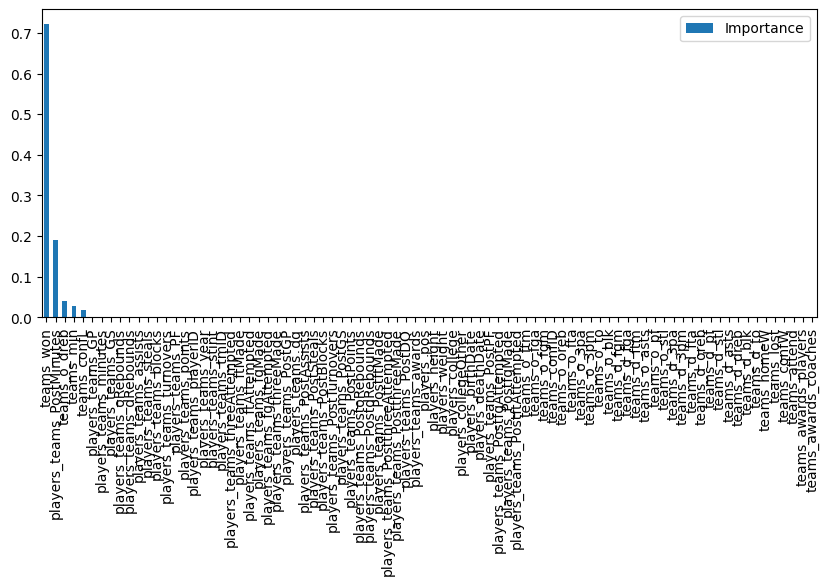

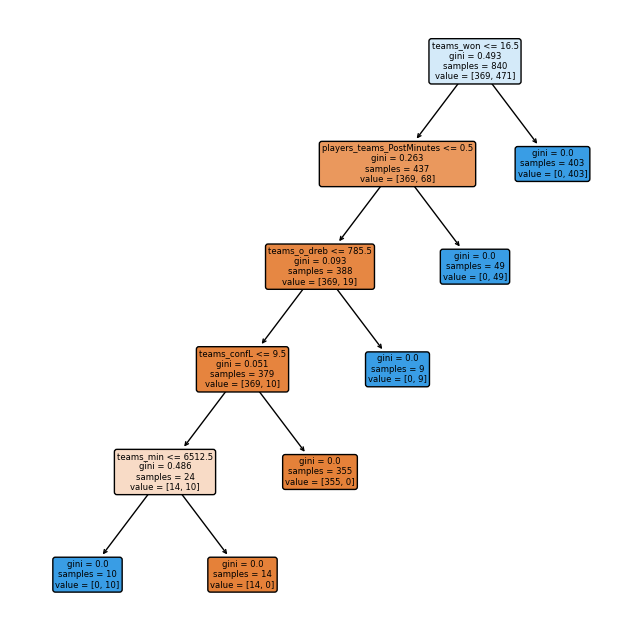


--- Second Conference ---

Time: 0.03 segundos
Precision: 0.73
Recall: 0.80
F1: 0.77
Accuracy: 0.69
AUC: 0.65


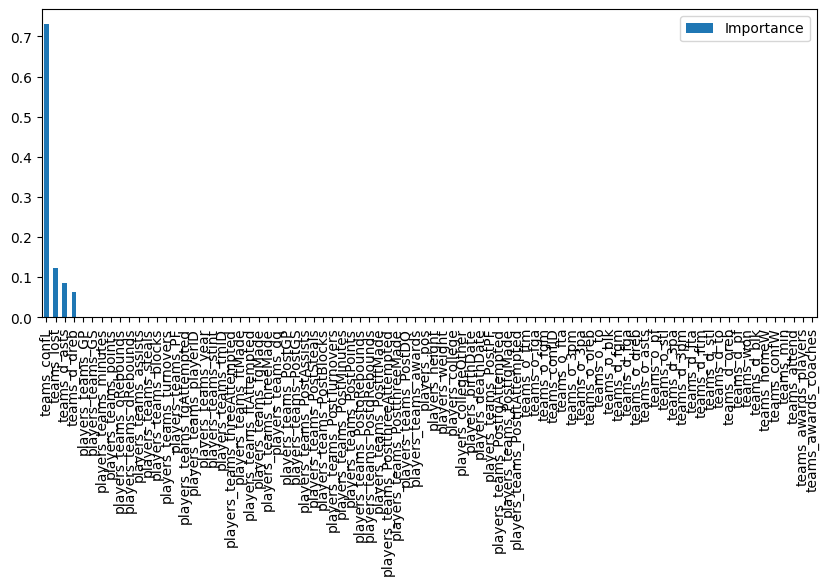

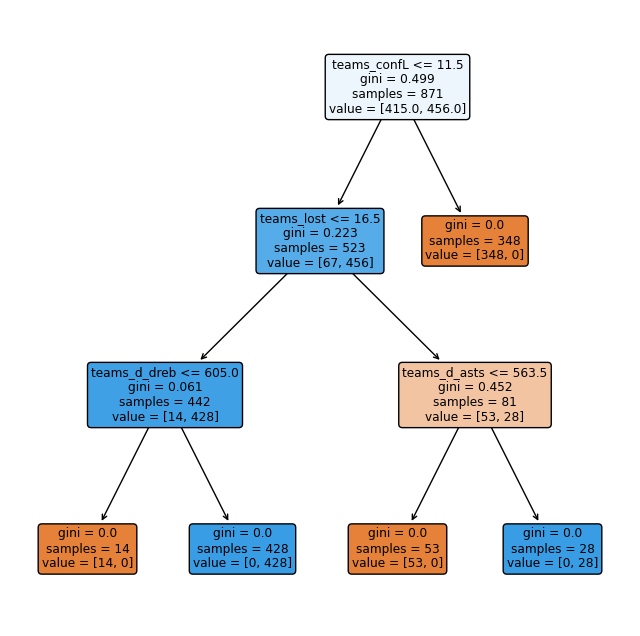

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import time

def second(data, year):

    train = data[data['players_teams_year'] < year]
    test = data[data['players_teams_year'] == year]

    X_train = train.drop("teams_playoff", axis=1)
    Y_train = train["teams_playoff"]

    X_test = test.drop("teams_playoff", axis=1)
    Y_test = test["teams_playoff"]

    start_time = time.time()
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, Y_train)
    end_time = time.time()
    
    y_pred_proba = decision_tree.predict_proba(X_test)[:, 1]
    test['probability'] = y_pred_proba
    team_probs = test.groupby(['players_teams_tmID', 'players_teams_year'])['probability'].mean().reset_index()
    team_probs['predicted_playoff'] = 0
    team_probs.loc[team_probs['probability'].nlargest(4).index, 'predicted_playoff'] = 1
    y_pred = test.merge(team_probs[['players_teams_tmID', 'players_teams_year', 'predicted_playoff']], on=['players_teams_tmID', 'players_teams_year'], how='left')['predicted_playoff']

    print(f"Time: {(end_time - start_time):.2f} segundos")
    print(f"Precision: {precision_score(Y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
    print(f"F1: {f1_score(Y_test, y_pred):.2f}")
    print(f"Accuracy: {accuracy_score(Y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(Y_test, y_pred):.2f}")
    

    # feature_importances_df = pd.DataFrame(decision_tree.feature_importances_, index=X_train.columns, columns=["Importance"])
    # feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
    # feature_importances_df.plot(kind='bar', figsize=(10, 4))
    # 
    # plt.figure(figsize=(8, 8))
    # plot_tree(decision_tree, filled=True, feature_names=X_test.columns.to_list(), rounded=True)
    # plt.show()
    
def first(year):
    data1 = players[players['teams_confID'] == 0]
    data2 = players[players['teams_confID'] == 1]
    print("--- First Conference ---\n")
    second(data1, year)
    print("\n--- Second Conference ---\n")
    second(data2,year)

first(10)